## Rover Lab Notebook
这个motebook包含课程中的方程，并提供了测试你映射方法的步骤。该notebook中需要完成的项目的步骤如下：

* 首先将notebook中所有的cells 跑一遍，验证代码及结果。

**注意：对于 online lab，数据已经提前收集并提供给我们了。如果希望尝试本地运行请便！然后继续continue point中的指示内容。**

* 以“Training Mode”运行simulator并记录一些数据。注意：如果记录的数据集太大，可能会奔溃，但事实上我们并不需要大量的数据，适量的数据即可。
* 改变数据目录路径为我们存放数据的目录。
* 测试数据上提供的函数。 

**继续**
* 写方程（或者修改现有的方程），以在地图上报告和标出障碍物和黄色石头的探测情况
* 以合适的步骤/方程补充‘process_image()’函数，将原始图像转换至世界图像（worldmap）
* 运行使用‘moviepy’函数的‘process——image()’函数以创建视频输出
* 一旦mapping正常运行，就可以开始修改‘perception.py’和‘decision.py’,使rover能够在‘autonomous mode’下导航和创建地图。

**运行一下单元室markdown cells中的代码高亮显示**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
在‘test_dataset’文件夹中提供了一些示例数据。该基础数据及已经足够让你往前练习和执行剩下的程序，但如果你想更仔细地磨练自己的方法，你可以自己记录数据，获取不同场景的样本。

下一步，随机读取并显示'test_dataset'文件夹的一个文件。

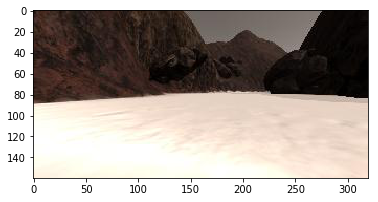

In [3]:
path = './test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data（校准数据）
读取并展示grid样本以及rock样本的校准图像。gird（网格）将用于透视变换，而rock（石头）图像将用于创建一个新的颜色选择策略，以识别出这些感兴趣的样本。

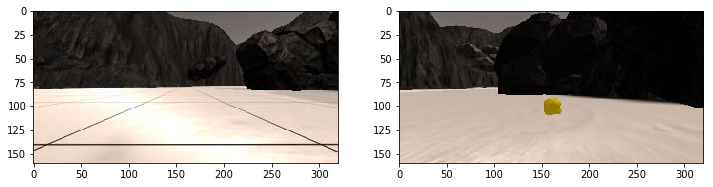

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = './calibration_images/example_grid1.jpg'
example_rock = './calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

定义课程中的透视变换函数（perspective transform function）并在一张图像中进行测试。

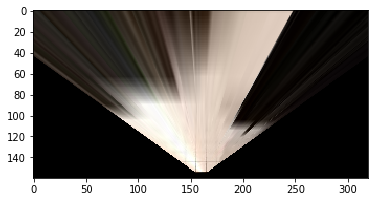

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
定义课程中的颜色阈值函数，并将其应用到warped过的图像

**TODO:** 最后，地图应该不仅包含可导航区域，还应该包含障碍物以及我们寻找的rock样本的位置。 修改该方程，或者写一个新的方程，返回障碍物（低于阈值的区域）和rock样本（校准图像中的黄色rock），这样就能将它们的区域也映射到世界坐标中了。

**Suggestion:** 考虑在你的颜色选择中施加一个下界和上界来更具体地选择颜色。可以自由发挥，甚至从其他库中获取功能。 这是一个使用open cv实现的例子[color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) .

**Beware:** 如果你才开始用OpenCV处理图像，请记住它在读/写图像时默认为“BGR”而不是“RGB”颜色空间，所以可能比较混乱。

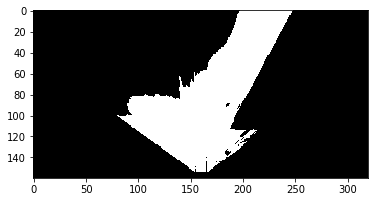

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
定义用于进行坐标变换的函数，并将它们应用于图像中。 

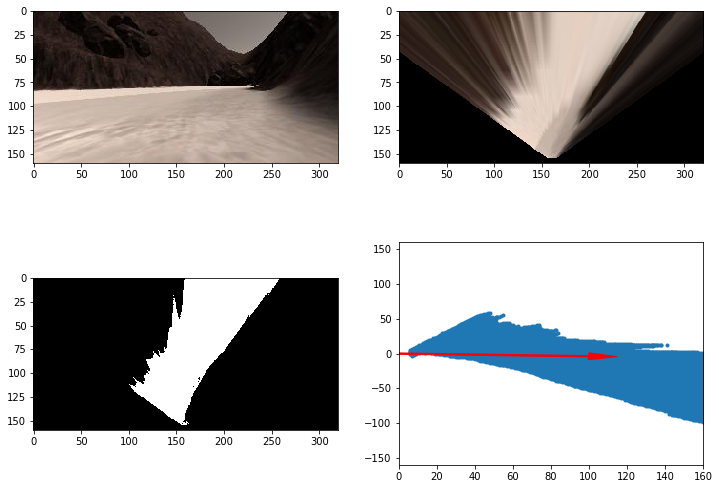

In [7]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    # or use this code:
    #x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    #y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    yaw_rad = yaw * np.pi/180
    xpix_rotated = xpix*np.cos(yaw_rad)-ypix*np.sin(yaw_rad)
    ypix_rotated = xpix*np.sin(yaw_rad)+ypix*np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = xpix_rot/scale + xpos
    ypix_translated = ypix_rot/scale + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world (读取保存的数据和世界真实地图 ) 
以下单元读入你保存的数据，并保存在‘pandas’字典。 这里你将读入一副“ground truth” map of the world，白色像素（像素值=1）代表可导航区域。

之后，定义一个类以在图像中存储遥测数据和路径名。 当实例化该类（`data = Databucket()`）时，就拥有一个名称为‘data’的全局变量，便可以在下面cell中的`process_image()`引用遥测和地图数据。

In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('./test_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('./calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images （写函数以处理保存的图像）
 
修改下面的`process_image()`函数，加上感知处理程序（上面定义的函数）以执行图像的分析和构图。 下面的cell联合`process_image()`和`moviepy`
视频处理包，从仿真器中获取并保存的图片基础上来创建视频。

简而言之，每张独立的图片将被传入`process_image()`中，并建立一张称为`output_image`的图片，这张图片会存储为视频中的某一帧。 你可以在分析过程的各个步骤中做一个马赛克，然后添加你喜欢的文本（下面提供的例子）。 

首先，可以简单的跑一下下面的三个cell看看发生什么，然后继续修改cell的代码，以便在输出视频验证你的构图程序。自由创作吧！

In [1]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
使用 [moviepy](https://zulko.github.io/moviepy/) 库处理图像，并创建一个视频。

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = './output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be speed up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output/test_mapping.mp4
[MoviePy] Writing video ./output/test_mapping.mp4


100%|██████████| 283/283 [00:05<00:00, 50.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/test_mapping.mp4 

CPU times: user 2.09 s, sys: 125 ms, total: 2.21 s
Wall time: 6.08 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [11]:
output = './output/test_mapping.mp4'
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))